In [1]:

import pandas as pd
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.jsonl to data.jsonl


In [3]:
# Load the JSONL file into a pandas DataFrame
df = pd.read_json('data.jsonl', lines=True)

In [4]:
df.head()

,response
0,"""Compare and contrast the philosophical founda..."
1,What are the key differences between classicis...
2,"Analyze the significance of the concept of ""co..."
3,"""Compare and contrast two different theories r..."
4,"""Analyze and discuss the role of artificial in..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   response  250000 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


# **Data Cleaning**

By inspecting the dataset, I discovered some rows that have the same word repeated many times. This needs to be cleaned by dropping these rows.

Below is an example of some of these rows:

In [6]:
# Adjust display options to show full content of DataFrame column
pd.set_option('display.max_colwidth', 200)

#Check rows with repeated values
repeated_rows = df[df['response'].str.contains(r'\b(\w+)\s+\1\s+\1\s+\1\b')]
print(repeated_rows)

<ipython-input-6-fc6e1fa13723>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  repeated_rows = df[df['response'].str.contains(r'\b(\w+)\s+\1\s+\1\s+\1\b')]


                                                                                                                                                                                                       response
14875   How does the concept of paradoxical paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox ...
68210                "Compare and contrast the key theories periodically periodically proposed in the history of X period (e.g period period period period period period period period period period period )."
82552   Explain the defining characteristics of an Empirical Research Study defining Empirical defining Research Research Study Study defining defining defining defining defining defining defining definin...
111862  Compare everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday

I will drop any row that has the same word repeated more than 4 times

In [7]:
# Dropping rows that have the same word repeated more than 4 times
def drop_repeated_words(df, max_repeats=4):

    # Splitting each row's text into words
    words = df['response'].str.split()

    # Checking for repeated words
    repeated_indices = []
    for i, row_words in enumerate(words):
        word_counts = {}
        for word in row_words:
            word_counts[word] = word_counts.get(word, 0) + 1
            if word_counts[word] > max_repeats:
                repeated_indices.append(i)
                break


    df.drop(repeated_indices, inplace=True)


In [8]:
drop_repeated_words(df)

In [9]:
# Now the prompts are 249118 instead of 250,000
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249118 entries, 0 to 249999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   response  249118 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [10]:
# There are no null values
df.isnull().sum()

response    0
dtype: int64

In [11]:
# Get the length of each prompt
df['prompt_length'] = df['response'].apply(lambda x: len(x.split()))
df['prompt_length']

0         20
1         13
2         19
3         12
4         13
          ..
249995    22
249996    22
249997    21
249998    13
249999    19
Name: prompt_length, Length: 249118, dtype: int64

In [12]:
# basic statistics of prompt lengths
df['prompt_length'].describe()

count    249118.000000
mean         16.648291
std           4.436962
min           2.000000
25%          14.000000
50%          16.000000
75%          19.000000
max          76.000000
Name: prompt_length, dtype: float64

In [13]:
import re

# Remove special characters and non-alphanumeric characters
df['response'] = df['response'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [14]:
# Remove leading and trailing whitespaces
df['response'] = df['response'].apply(lambda x: x.strip())

# **Data Preprocessing**

In [15]:
# Tokenization
def preprocessing(text):
    doc = nlp(text)

    # Extract tokens from the SpaCy document
    tokens = [token.text for token in doc]
    return tokens

df['tokens'] = df['response'].apply(preprocessing)


In [16]:
df

,response,prompt_length,tokens
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]"
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]"
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]"
...,...,...,...
249995,What is the significance of the concept of homeostasis in biology and how does it relate to the functioning of biological systems,22,"[What, is, the, significance, of, the, concept, of, homeostasis, in, biology, and, how, does, it, relate, to, the, functioning, of, biological, systems]"
249996,Discuss the role of cellular respiration in energy production within living organisms and how it contributes to the overall functioning of cells,22,"[Discuss, the, role, of, cellular, respiration, in, energy, production, within, living, organisms, and, how, it, contributes, to, the, overall, functioning, of, cells]"
249997,In the field of artificial intelligence explain the difference between supervised and unsupervised learning and provide a reallife example of each,21,"[In, the, field, of, artificial, intelligence, explain, the, difference, between, supervised, and, unsupervised, learning, and, provide, a, reallife, example, of, each]"
249998,Compare and contrast the key differences between Classical and Quantum Mechanics in physics,13,"[Compare, and, contrast, the, key, differences, between, Classical, and, Quantum, Mechanics, in, physics]"


In [17]:
# Lemmatization
lemmatized_responses = []

for token in df['tokens']:
    doc = nlp(" ".join(token))
    lemmatized_response = [token.lemma_ for token in doc]
    lemmatized_responses.append(lemmatized_response)

In [27]:
lemmatized_responses[0]

['compare',
 'and',
 'contrast',
 'the',
 'philosophical',
 'foundation',
 'of',
 'two',
 'major',
 'school',
 'of',
 'thought',
 'in',
 'the',
 'field',
 'of',
 'psychology',
 'Behaviorism',
 'and',
 'Cognitivism']

In [28]:
# Remove Stop words
filtered_responses = []
for response in lemmatized_responses:
    filtered_response = [token for token in response if not nlp.vocab[token].is_stop]
    filtered_responses.append(filtered_response)


In [29]:
filtered_responses[0]

['compare',
 'contrast',
 'philosophical',
 'foundation',
 'major',
 'school',
 'thought',
 'field',
 'psychology',
 'Behaviorism',
 'Cognitivism']

In [30]:
# Remove punctuation
punctuations = "?:!.,;"
filtered_responses_without_punctuation = []

for response in filtered_responses:
    filtered_response = [word for word in response if word not in punctuations]
    filtered_responses_without_punctuation.append(filtered_response)

In [31]:
filtered_responses_without_punctuation[0]

['compare',
 'contrast',
 'philosophical',
 'foundation',
 'major',
 'school',
 'thought',
 'field',
 'psychology',
 'Behaviorism',
 'Cognitivism']

In [33]:
# POS tagging
def pos_tagging(filtered_responses):
    tagged_responses = []
    for response in filtered_responses:
        doc = nlp(" ".join(response))
        tagged_response = [(token.text, token.pos_) for token in doc]
        tagged_responses.append(tagged_response)
    return tagged_responses



In [34]:
tagged_responses = pos_tagging(filtered_responses)

In [35]:
# Named Entity Recognition (NER)
def ner_tagging(filtered_responses):
    tagged_responses = []
    for response in filtered_responses:
        doc = nlp(" ".join(response))
        tagged_response = [(ent.text, ent.label_) for ent in doc.ents]
        tagged_responses.append(tagged_response)
    return tagged_responses

In [36]:
ner_tagged_responses = ner_tagging(filtered_responses)

# **Data Analysis and insights**

In [37]:
# This method returns a list of all the words in the dataset after removing stopwords, removing punctuation, lowercasing, and lemmatization

def extract_vocab(filtered_responses):
    vocab = set()
    for response in filtered_responses:
        for word in response:
            vocab.add(word)
    return list(vocab)


In [38]:
# My Vocab
# Word_list contains all the words "Vocab" of my dataset
words_list = extract_vocab(filtered_responses)
words_list

['injury',
 'prepare',
 'cocaine',
 'stagebase',
 'colony',
 '50',
 'athlete',
 'ontological',
 'Allport',
 'Galton',
 'feel',
 'possibility',
 'Lovelaces',
 'Gene',
 'aperture',
 'derive',
 'welcome',
 'association',
 'coevolution',
 'dilemma',
 'orator',
 'ethnocentrism',
 'Bernard',
 'Genome',
 'urban',
 'workshop',
 'arise',
 'maslow',
 'East',
 'isought',
 'quadratic',
 'Contemporary',
 'Ferdinand',
 'unmitigated',
 'Abnormal',
 'incrementum',
 'nativist',
 'behavior',
 'primordial',
 'Keynesianism',
 'Becks',
 'memorable',
 'Democracy',
 'Ergo',
 'nondeterministic',
 'remotely',
 'learnercentered',
 'French',
 'connect',
 'Pink',
 'spatial',
 'paradigms',
 'Haber',
 'Derek',
 'poststructuralism',
 'conceptual',
 'feminist',
 'describe',
 'Basic',
 'Entrepreneurship',
 'purchase',
 'upcoming',
 'generalize',
 'habit',
 'Erik',
 'AI',
 'Heideggers',
 'manner',
 'powerknowledge',
 'Tools',
 'group',
 'unintended',
 'assimilation',
 '110',
 'Beowulf',
 'Schizophrenia',
 'susceptibili

In [39]:
# This methods returns a dictionary where each 'key' is a word in the dataset and each 'value' is the frequency of that word in the dataset.
def termFrequency(filtered_responses):
    term_freq_dict = {}
    for response in filtered_responses:
        for word in response:
            if word not in nlp.Defaults.stop_words:  # Check if word is not a stop word
                term_freq_dict[word] = term_freq_dict.get(word, 0) + 1
    return term_freq_dict

In [40]:
#word_freq_dict having each word in the dataset and it's corresponding count
term_freq = termFrequency(filtered_responses)
term_freq

{'compare': 57516,
 'contrast': 57024,
 'philosophical': 19302,
 'foundation': 5210,
 'major': 6109,
 'school': 988,
 'thought': 2309,
 'field': 56935,
 'psychology': 19716,
 'Behaviorism': 652,
 'Cognitivism': 239,
 'key': 53012,
 'difference': 38508,
 'classicism': 143,
 'romanticism': 145,
 'literature': 4432,
 'art': 510,
 'analyze': 10890,
 'significance': 57396,
 'concept': 42367,
 'cognitive': 11452,
 'dissonance': 1329,
 'social': 4876,
 'implication': 6437,
 'understand': 7349,
 'human': 20416,
 'behavior': 7795,
 'different': 8641,
 'theory': 56283,
 'relate': 2707,
 'development': 35789,
 'discuss': 16787,
 'role': 11785,
 'artificial': 2064,
 'intelligence': 3089,
 'future': 2958,
 'education': 27987,
 'explain': 54501,
 'quantum': 28132,
 'entanglement': 3536,
 'high': 6951,
 'student': 14382,
 'importance': 10559,
 'critical': 8400,
 'thinking': 8404,
 'provide': 10414,
 'example': 11766,
 'apply': 7465,
 'reallife': 715,
 'situation': 797,
 'Fourier': 109,
 'series': 14,

In [41]:
# Getting the most frequent word
def most_frequent_word(term_freq_dict):

    max_freq_word = max(term_freq_dict, key=term_freq_dict.get)
    max_freq = term_freq_dict[max_freq_word]
    return max_freq_word, max_freq

most_freq_word, freq = most_frequent_word(term_freq)
print("Most frequent word:", most_freq_word)
print("Frequency:", freq)

Most frequent word: compare
Frequency: 57516


As we can see, the most frquent word is **"Compare"**. This can provide insights about our data that most of the prompts focus on prompting comparisons between different entities, concepts, ideas, or phenomena.

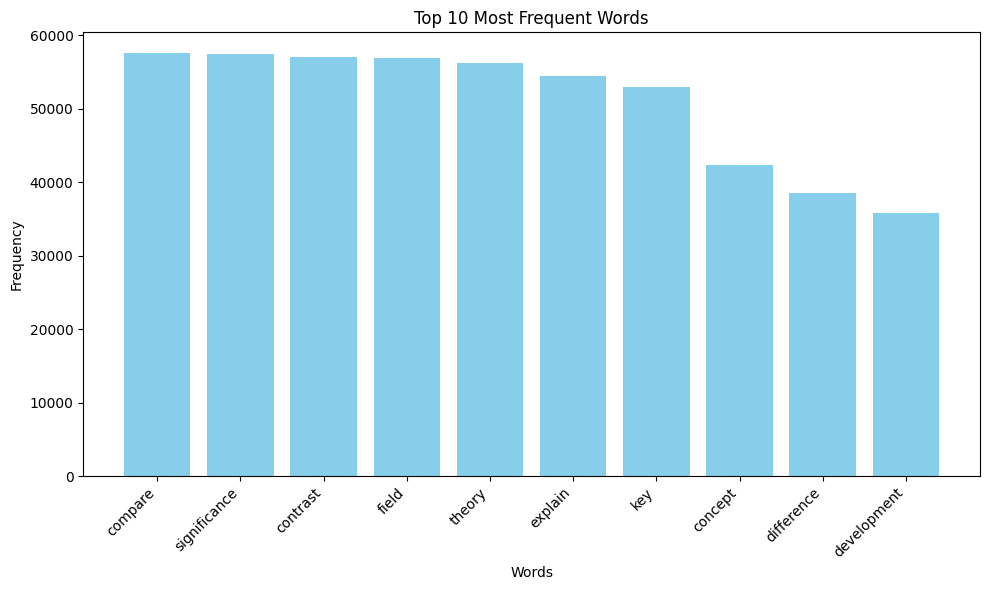

In [43]:
import matplotlib.pyplot as plt

def plot_top_10_words(term_freq_dict):

    sorted_freq = sorted(term_freq_dict.items(), key=lambda x: x[1], reverse=True)


    top_10_words = sorted_freq[:10]


    words = [item[0] for item in top_10_words]
    frequencies = [item[1] for item in top_10_words]


    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Frequent Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_top_10_words(term_freq)

In [44]:
# This method calculates the docunemt frequency of each word, which means how many prompts contain each word.
def wordDocFreq(filtered_responses):
    doc_freq_dict = {}
    for response in filtered_responses:
        seen_words = set()
        for word in response:
            if word not in seen_words:
                doc_freq_dict[word] = doc_freq_dict.get(word, 0) + 1
                seen_words.add(word)
    return doc_freq_dict

In [45]:
doc_freq = wordDocFreq(filtered_responses)
doc_freq

{'compare': 57516,
 'contrast': 56974,
 'philosophical': 19268,
 'foundation': 5208,
 'major': 6107,
 'school': 980,
 'thought': 2305,
 'field': 56809,
 'psychology': 19336,
 'Behaviorism': 652,
 'Cognitivism': 239,
 'key': 53002,
 'difference': 37749,
 'classicism': 143,
 'romanticism': 145,
 'literature': 4399,
 'art': 493,
 'analyze': 10889,
 'significance': 57396,
 'concept': 42281,
 'cognitive': 11371,
 'dissonance': 1324,
 'social': 4751,
 'implication': 6436,
 'understand': 7344,
 'human': 20266,
 'behavior': 7792,
 'different': 8632,
 'theory': 54240,
 'relate': 2704,
 'development': 35407,
 'discuss': 16782,
 'role': 11782,
 'artificial': 2062,
 'intelligence': 3029,
 'future': 2957,
 'education': 27688,
 'explain': 54482,
 'quantum': 25929,
 'entanglement': 3536,
 'high': 6945,
 'student': 14274,
 'importance': 10559,
 'critical': 8321,
 'thinking': 8329,
 'provide': 10406,
 'example': 11766,
 'apply': 7465,
 'reallife': 715,
 'situation': 797,
 'Fourier': 109,
 'series': 14,

In [46]:
# Finding the word with the highest document frequency count
def word_with_highest_doc_freq(doc_freq_dict):

    max_freq_word = max(doc_freq_dict, key=doc_freq_dict.get)
    max_freq = doc_freq_dict[max_freq_word]
    return max_freq_word, max_freq


max_freq_word, freq = word_with_highest_doc_freq(doc_freq)
print("Word with highest document frequency:", max_freq_word)
print("Document Frequency:", freq)

Word with highest document frequency: compare
Document Frequency: 57516


Again, "**Compare**" has the highest document frequency. This again means that most of the documents contain questions in the form of comparison

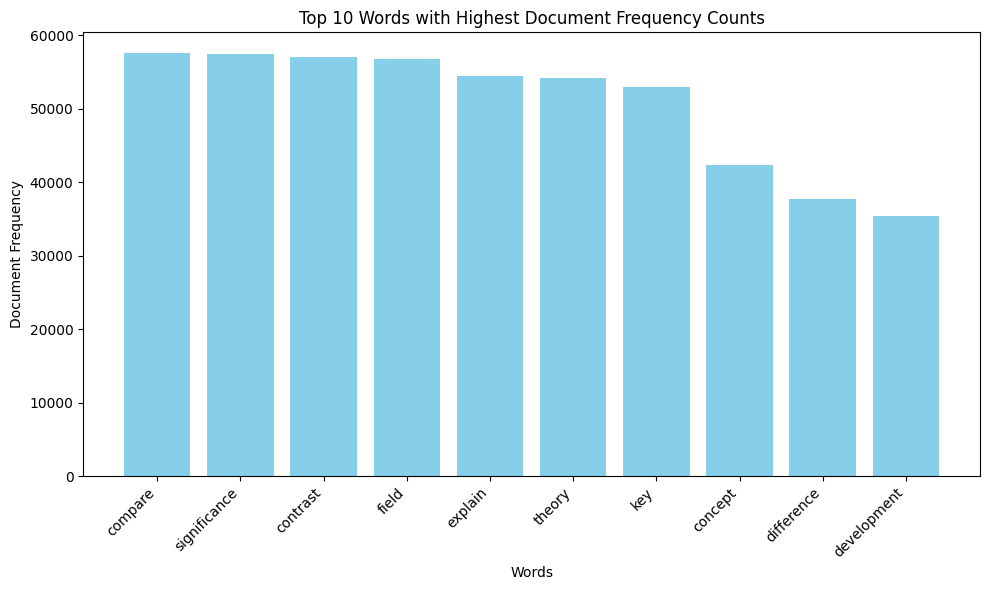

In [47]:
import matplotlib.pyplot as plt

sorted_doc_freq = sorted(doc_freq.items(), key=lambda x: x[1], reverse=True)


top_10_words = sorted_doc_freq[:10]


words = [item[0] for item in top_10_words]
frequencies = [item[1] for item in top_10_words]


plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Document Frequency')
plt.title('Top 10 Words with Highest Document Frequency Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
# This function calculates the IDF score for each word in the entire dataset
# The IDF score indicates how unique or important each word is relative to the entire corpus of documents.
import math

def calculate_idf(filtered_responses):
    total_documents = len(filtered_responses)
    word_document_count = {}

    for response in filtered_responses:
        seen_words = set()
        for word in response:
            if word not in seen_words:
                word_document_count[word] = word_document_count.get(word, 0) + 1
                seen_words.add(word)


    idf_scores = {}
    for word, doc_count in word_document_count.items():
        idf_scores[word] = math.log(total_documents / (doc_count + 1))

    return idf_scores

The IDF score indicates how unique or important each word is relative to the entire corpus of documents

In [49]:
#IDF score for each word
idf_scores = calculate_idf(filtered_responses)
idf_scores

{'compare': 1.465846123513262,
 'contrast': 1.4753141046622402,
 'philosophical': 2.5594290928502232,
 'foundation': 3.867538781030934,
 'major': 3.7083272924376023,
 'school': 5.537109499210763,
 'thought': 4.682412257947121,
 'field': 1.4782143132249528,
 'psychology': 2.5559063207255335,
 'Behaviorism': 5.944104829499694,
 'Cognitivism': 6.945043035434134,
 'key': 1.5475781640702146,
 'difference': 1.8869412040989546,
 'classicism': 7.455868659200124,
 'romanticism': 7.442075337067789,
 'literature': 4.036322138869773,
 'art': 6.223146441588203,
 'analyze': 3.130081742849119,
 'significance': 1.4679346426426827,
 'concept': 1.7735652162210478,
 'cognitive': 3.0867724860052346,
 'dissonance': 5.236514220355803,
 'social': 3.9593610977336446,
 'implication': 3.6558640867235095,
 'understand': 3.5239068701681475,
 'human': 2.508932732256812,
 'behavior': 3.4647007849325644,
 'different': 3.3623346105406027,
 'theory': 1.5244895997536287,
 'relate': 4.5228247674955435,
 'development': 1

In [50]:
# Finding the word with the highest IDF score
max_idf_word = max(idf_scores, key=idf_scores.get)
max_idf_score = idf_scores[max_idf_word]

print("Word with highest IDF score:", max_idf_word)
print("IDF Score:", max_idf_score)

Word with highest IDF score: connectionism
IDF Score: 11.73253477821618


The IDF score reflects how much information the word provides.The higher the IDF score, the more rare or unique the word is, and therefore, it's considered more important or significant in distinguishing between documents.

Words with high IDF scores are often indicative of terms that are crucial for understanding specific topics or concepts in the dataset. **"connectionism"** may be a key concept within psychology or cognitive science

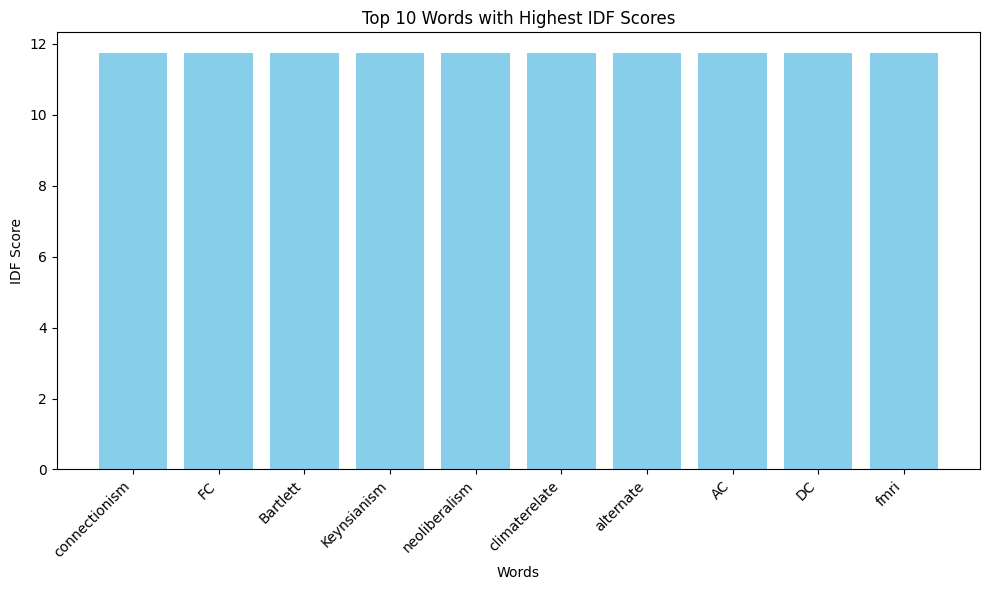

In [51]:
import matplotlib.pyplot as plt

sorted_idf_scores = sorted(idf_scores.items(), key=lambda x: x[1], reverse=True)

top_10_words = sorted_idf_scores[:10]

words = [item[0] for item in top_10_words]
idf_scores = [item[1] for item in top_10_words]

plt.figure(figsize=(10, 6))
plt.bar(words, idf_scores, color='skyblue')
plt.xlabel('Words')
plt.ylabel('IDF Score')
plt.title('Top 10 Words with Highest IDF Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [52]:
#This function Calculates the TF-IDF score for each word in each preprocessed response individually.
import math

def calculate_tf_idf(filtered_responses):
    # Calculate TF (Term Frequency)
    tf_scores = {}
    for response in filtered_responses:
        for word in response:
            tf_scores[word] = tf_scores.get(word, 0) + 1

    # Calculate IDF (Inverse Document Frequency)
    total_documents = len(filtered_responses)
    word_document_count = {}
    for response in filtered_responses:
        seen_words = set()  # Keep track of words already seen in the current response
        for word in response:
            if word not in seen_words:  # Only count each word once per response
                word_document_count[word] = word_document_count.get(word, 0) + 1
                seen_words.add(word)

    idf_scores = {}
    for word, doc_count in word_document_count.items():
        idf_scores[word] = math.log(total_documents / (doc_count + 1))  # Add 1 to avoid division by zero

    # Calculate TF-IDF (Term Frequency-Inverse Document Frequency)
    tf_idf_scores = {}
    for word, tf_score in tf_scores.items():
        tf_idf_scores[word] = tf_score * idf_scores.get(word, 0)

    return tf_idf_scores

The TF-IDF score is a statistical measure used to evaluate the importance of a word in a document relative to a collection of document.

a high TF-IDF score for a word in a document indicates that the word is both frequent within that document and rare across the entire corpus, making it more likely to be relevant to the content of that document.

In [53]:
tf_idf_scores = calculate_tf_idf(filtered_responses)
tf_idf_scores

{'compare': 84309.60563998877,
 'contrast': 84128.31150425959,
 'philosophical': 49402.10035019501,
 'foundation': 20149.877049171166,
 'major': 22654.17142950131,
 'school': 5470.664185220234,
 'thought': 10811.689903599901,
 'field': 84162.13192346269,
 'psychology': 50392.24901942462,
 'Behaviorism': 3875.5563488338007,
 'Cognitivism': 1659.865285468758,
 'key': 82040.21363369022,
 'difference': 72662.33188744255,
 'classicism': 1066.1892182656177,
 'romanticism': 1079.1009238748293,
 'literature': 17888.979719470834,
 'art': 3173.8046852099837,
 'analyze': 34086.59017962691,
 'significance': 84253.57674911941,
 'concept': 75140.63751563714,
 'cognitive': 35349.718509731945,
 'dissonance': 6959.327398852862,
 'social': 19305.844712549253,
 'implication': 23532.79712623923,
 'understand': 25897.191588865717,
 'human': 51222.37066175507,
 'behavior': 27007.34261854934,
 'different': 29053.93336968135,
 'theory': 85802.8481429335,
 'relate': 12243.286645610437,
 'development': 69823.94

In [54]:
# Finding the highest TF-IDF score
max_tfidf_word = max(tf_idf_scores, key=tf_idf_scores.get)
max_tfidf_score = tf_idf_scores[max_tfidf_word]

print("Word with highest TF-IDF score:", max_tfidf_word)
print("TF-IDF Score:", max_tfidf_score)

Word with highest TF-IDF score: theory
TF-IDF Score: 85802.8481429335


A high TF-IDF score suggests that the word **"theory"** is significant and representative of the content in the dataset. It indicates that **"theory**" appears frequently in some documents (high TF) but is relatively rare across the entire dataset (high IDF), making it a distinguishing term.

Moreover, The presence of **"theory"** as the word with the highest TF-IDF score may indicate that the dataset contains documents with a strong focus on theoretical concepts or discussions. It suggests that the topic or theme revolving around **"theory"** is central to the dataset.

In [55]:
# Finding the top 10 highest TF-IDF scores
sorted_tf_idf_scores = sorted(tf_idf_scores.items(), key=lambda x: x[1], reverse=True)

top_10_words = sorted_tf_idf_scores[:10]

for i, (word, score) in enumerate(top_10_words, 1):
    print(f"{i}. Word: {word}, TF-IDF Score: {score}")

1. Word: theory, TF-IDF Score: 85802.8481429335
2. Word: compare, TF-IDF Score: 84309.60563998877
3. Word: significance, TF-IDF Score: 84253.57674911941
4. Word: field, TF-IDF Score: 84162.13192346269
5. Word: contrast, TF-IDF Score: 84128.31150425959
6. Word: explain, TF-IDF Score: 82843.58849768207
7. Word: key, TF-IDF Score: 82040.21363369022
8. Word: concept, TF-IDF Score: 75140.63751563714
9. Word: difference, TF-IDF Score: 72662.33188744255
10. Word: development, TF-IDF Score: 69823.94161631221
